# GORILLA plotting tutorial

With the plotting option of GORILLA it is possible to compute and plot the orbit of a particle in a toroidal magnetic fusion device. For the visualization of the orbit, Poincare plots are used. The program also computes various constants of motion to check how the obtained results behave with respect to numerical accuracy.  

This tutorial guides through different input options of the code and shows a way how to execute the code with PYTHON. In principle one could change the repective options in the namelist-files like 'gorilla.inp' or 'tetra_grid.inp' per hand and then start the main executable 'test_gorilla-main.x'. However, here we will show how one can instead control these options dynamically in a PYTHON script using the the *f90nml*-namelist package.

***

## Preliminary: Using *f90nml* and *os* to alter namelists

First we load the *f90nml* package after installing it e.g. using pip. Additionally we load the default module *os* (this is used to execute shell commands in PYTHON such as getting the current working directory path, creating folders and starting the main executable of GORILLA). We want to note that the default module *subprocess* is general considered preferable to *os*. However, for our very limited interaction with the operating system, *os* completly suffices.

In [1]:
import f90nml
import os

path_jupyter = os.getcwd()
print(path_jupyter)

/afs/itp.tugraz.at/user/grassl_g/MT/GORILLA/JUPYTER


The namelist `tetra_grid_nml` we want to look at in this example is located in the file `tetra_grid.inp`, which can be found in the *INPUT* folder. So we provide the correct path to that file and read it into a python dictionary. Make sure to set the *end_comma* property of the generated namelist-object to *True*.

In [2]:
filename= path_jupyter + '/../INPUT/tetra_grid.inp'
tetra_grid = f90nml.read(filename)
tetra_grid.end_comma = True
print(tetra_grid)

&tetra_grid_nml
    n1 = 100,
    n2 = 40,
    n3 = 40,
    grid_kind = 3,
    g_file_filename = 'MHD_EQUILIBRIA/g_file_for_test',
    convex_wall_filename = 'MHD_EQUILIBRIA/convex_wall_for_test.dat',
    netcdf_filename = 'MHD_EQUILIBRIA/netcdf_file_for_test.nc',
    boole_n_field_periods = .true.,
    n_field_periods_manual = 1,
    sfc_s_min = 0.1,
    theta_geom_flux = 1,
    theta0_at_xpoint = .true.,
    boole_write_mesh_obj = .false.,
    filename_mesh_rphiz = 'mesh_rphiz.obj',
    filename_mesh_sthetaphi = 'mesh_sthetaphi.obj',
/


You can now access and change the values of the listed *key:value pairs* in that dictonary by first indexing the wanted namelist and then the keyname:

In [3]:
print('The current number of grid points n1 is ' + str(tetra_grid['tetra_grid_nml']['n1']))

tetra_grid['tetra_grid_nml']['n1'] = 101

print('The new value of n1 is ' + str(tetra_grid['tetra_grid_nml']['n1']))

The current number of grid points n1 is 100
The new value of n1 is 101


After we have altered the desired options, we write our changed namelist to a new namelist-file (this is done to preserve the comments in the original file as well as the default settings). The final file should be located in the same folder as the main excutable `test_gorilla_main.x` so that it can then properly acess the file.

In [4]:
new_filename = path_jupyter + '/../tetra_grid.inp'
tetra_grid.write(new_filename, force = True);

The commments in the original `.inp` file explain the different options of the namelist `tetra_grid_nml`. We delete now the just created file, as it was just for demonstration purposes. Later we will create the modified files in the actual RUN folder where we want to execute GORILLA.

In [5]:
if (True):
  os.remove(new_filename)

***

## Initialization

Assuming the proper packages (*f90nml* and *os*) are already loaded, the PYTHON code first needs to know where to find the used files. Therefore, it is necessary to specify some paths. 

For the here provided default values to work
* the folder *GORILLA* must not have been changed
* **the current working directory** has to be the folder of this JUPYTER notebook (check the print output of the next cell)
* and the code cells of this section have to be executed in order. 

**If in doubt, restart the notebook to clear the working variables and to reset the current path to this notebook.**
 
First, we get the current working directory:

In [6]:
path_script = os.getcwd()
#default: path_script= os.getcwd();
print(path_script)

/afs/itp.tugraz.at/user/grassl_g/MT/GORILLA/JUPYTER


The path of the main folder *GORILLA*:

In [7]:
path_main = path_script + '/..'
#default: path_main= path_script + '/..'

Next, the path where the FORTRAN code should be executed. Here we create a new clean RUN folder for that. Note that the explicit shell commands depend on the used **operating system**.

In [8]:
path_RUN = path_main + '/EXAMPLES/PYTHON_RUN/plot_poincare'
#default path_RUN= path_main + '/EXAMPLES/PYTHON_RUN/plot_poincare'

if not os.path.exists(path_RUN):
  os.makedirs(path_RUN)

os. chdir(path_RUN)
if os.listdir('../plot_poincare/'):
  os.system('rm -r ../plot_poincare/*')

In the *INPUT* folder the input files for the GORILLA code are already prepared. All input variables have a default value. These input files will be loaded into the PYTHON script later on.

In [9]:
path_inp_files = path_main + '/INPUT'
#default path_inp_files= path_main + '/INPUT';

GORILLA will create as output several data files. By default they are saved to the same directory where the executable was run from (in our case the RUN folder). We will use these files to make several plots and then save them into a seperate folder (in our case a folder in the directory of this notebook).

In [10]:
name_data_folder ='/data_plots/plot_poincare'
path_data_plots = path_script + name_data_folder

if not os.path.exists(path_data_plots):
  os.makedirs(path_data_plots)


***

## Loading the namelists

The *GORILLA* code requires some input files. All possible options for the code can be set in these files. In the INPUT folder, there are already default input files. In these files one can also find short explanations for ervery variable. In this script all input files will be loaded. The general way of working with the namelists in these input files using *f90nml* is explained in the preliminary at the top of this notebook.

In [11]:
gorilla = f90nml.read(path_inp_files + '/gorilla.inp')
gorilla.end_comma = True
tetra_grid = f90nml.read(path_inp_files + '/tetra_grid.inp')
tetra_grid.end_comma = True
gorilla_plot = f90nml.read(path_inp_files + '/gorilla_plot.inp')
gorilla_plot.end_comma = True


***

## Input file gorilla.inp

### Electrostatic potential

Change in the electrostatic potential within the plasma volume in Gaussian units 

In [12]:
gorilla['gorillanml']['eps_Phi'] = 0

### Coordinate system

1 ... ($R$,$\varphi$,$Z$) cylindrical coordinate system

2 ... ($s$,$\vartheta$,$\varphi$) symmetry flux coordinate system 

In [13]:
gorilla['gorillanml']['coord_system'] = 2

### Particle species

1 ... electron

2 ... deuterium ion

3 ... alpha particle

In [14]:
gorilla['gorillanml']['ispecies'] = 2

### Periodic coordinate particle re-location

*True* ... Particles are re-located at initialization in the case of a periodic coordinate, if they are outside the computation domain.

*False* .. Particles are not re-located at initialization (This might lead to error if particles are outside the computation domain)

In [15]:
gorilla['gorillanml']['boole_periodic_relocation'] = True

### GORILLA pusher options

1 ... numerical RK pusher

2 ... polynomial pusher

In [16]:
gorilla['gorillanml']['ipusher'] = 2

### Numerical pusher options

##### accuracy for integration step

*False* ... RK4

*True* ... adaptive ODE45

In [17]:
gorilla['gorillanml']['boole_pusher_ode45'] = False

##### ODE45 relative accuracy (pusher orbit)

In [18]:
gorilla['gorillanml']['rel_err_ode45'] = 1e-8

##### Physical time - orbit parameter relation

*False* ... $dt/d\tau$ is a linear function of position in each tetrahedron

*True* ... $dt/d\tau$ is a constant averaged quantity in each tetrahedron

In [19]:
gorilla['gorillanml']['boole_dt_dtau'] = True

##### Precomputation for Newton iterations

*False* ... Compute coefficients for 2nd order polynomial solution (Newton velocity and acceleration) in each tetrahedron ($dzd\tau$) without precomputation

*True* ... Use precomputation of coefficients for 2nd order polynomial solution (Newton velocity and acceleration)

In [20]:
gorilla['gorillanml']['boole_newton_precalc'] = False

### Polynomial pusher options

##### Polynomial order for orbit pusher

In [21]:
gorilla['gorillanml']['poly_order'] = 4

##### Settings for precomputation of coefficients

0 ... No precomputation: All coefficients are computed on the fly (power of matrices)

1 ... Precomputation of coefficients and factorization of powers of $v_{\perp}$

2 ... Same as 1 but with further precomputation of operatorb in $b$

3 ... Extended precomputation of coefficients for constant $v_{\perp}$

(Precomputation is done for each tetrahedron for constant perpinv) NOT IMPLEMENTED YET

In [22]:
gorilla['gorillanml']['i_precomp'] = 0

##### Face prediction with 2nd order polynomial

*True* ... Face guessing algorithm is used

*False* ... NOT used

In [23]:
gorilla['gorillanml']['boole_guess'] = True

### Processing of particle handover to tetrahedron neighbour

1 ... Processing with special treatment of periodic boundaries and manipulation of periodic position values

2 ... Position exchange via Cartesian variables (skew_coordinates) - Necessary precomputation is included

In [24]:
gorilla['gorillanml']['handover_processing_kind'] = 1

### Noise on axisymmetric electromagnetic field (Tokamak)

##### Add axisymmetric noise to vector potential $A_k$

*True* ... Add axisymmetric random noise ($\xi$ = 0 ... 1) to the co-variant component of the vector potential $A_k$

$A_k' = A_k(1 + \epsilon{}_A\xi)$

*False* ... Add no axisymmetric noise to $A_k$

In [25]:
gorilla['gorillanml']['boole_axi_noise_vector_pot'] = False

##### Relative Magnitude of axisymmetric random noise $\epsilon{}_A$ of vector potential

In [26]:
gorilla['gorillanml']['axi_noise_eps_A'] = 1e-1

##### Add axisymmetric noise to electrostatic potential $\phi$

*True* ... Add axisymmetric random noise ($\xi$ = 0 ... 1) to the electrostatic potential $\phi$

$\phi' = \phi(1 + \epsilon{}_{\phi}\xi)$

*False* ... Add no axisymmetric noise to $\phi$

In [27]:
gorilla['gorillanml']['boole_axi_noise_elec_pot'] = False

##### Relative Magnitude of axisymmetric random noise $\epsilon{}_{\phi}$ of electrostatic potential

In [28]:
gorilla['gorillanml']['axi_noise_eps_Phi'] = 3e-1

##### Add non-axisymmetric noise to vector potential $A_k$

In [29]:
gorilla['gorillanml']['boole_non_axi_noise_vector_pot'] = False

##### Relative Magnitude of non-axisymmetric random noise $\epsilon{}_A$ of vector potential

In [30]:
gorilla['gorillanml']['non_axi_noise_eps_A'] = 1e-4

### Harmonic perturbation on axisymmetric electromagnetic field

##### Add helical harmonic perturbation of $A_{\varphi}$

*False* ... no perturbation

*True* ... helical perbutation on:

$A_{\varphi}' = A_{\varphi} + A_{\varphi}* \epsilon{}_{A_{\varphi}}^{helical} * \cos{(m_{fourier}*\vartheta +n_{fourier}*\varphi)}$

In [31]:
gorilla['gorillanml']['boole_helical_pert'] = False

##### Amplitude of helical harmonic perturbation $\epsilon{}_{A_{\varphi}}^{helical}$

In [32]:
gorilla['gorillanml']['helical_pert_eps_Aphi'] = 1e-1

##### Fourier modes ($m_{fourier}$, $n_{fourier}$) of helical perturbation 

In [33]:
gorilla['gorillanml']['helical_pert_m_fourier'] = 2
gorilla['gorillanml']['helical_pert_n_fourier'] = 2


***

## Input file tetra_grid.inp

### Grid size

Rectangular: $n_R$, Field-aligned: $n_s$

In [34]:
tetra_grid['tetra_grid_nml']['n1'] = 100

Rectangular: $n_{\varphi}$, Field-aligned: $n_{\varphi}$ 

In [35]:
tetra_grid['tetra_grid_nml']['n2'] = 30

Rectangular: $n_Z$, Field-aligned: $n_{\vartheta}$

In [36]:
tetra_grid['tetra_grid_nml']['n3'] = 30

### Grid kind

1 ... rectangular grid for axisymmetric EFIT data (g-file)

2 ... field-aligned grid for axisymmetric EFIT data (g-file)

3 ... field-aligned grid for non-axisymmetric VMEC (netcdf)

In [37]:
tetra_grid['tetra_grid_nml']['grid_kind'] = 3


### Source files of fields

GORILLA needs the electromagnetic fields as input to perform the trajectory integration. Additionally, the fields are also needed to generate the field-aligned grid or to perform the triangle classification when dealing with the WEST geometry. The location (default is the folder *MHD_EQUILIBRIA*) and names of the corresponding MHD equilibrium files are specified here:

In [38]:
tetra_grid['tetra_grid_nml']['g_file_filename'] = 'MHD_EQUILIBRIA/g_file_for_test' 
tetra_grid['tetra_grid_nml']['convex_wall_filename'] = 'MHD_EQUILIBRIA/convex_wall_for_test.dat' 
tetra_grid['tetra_grid_nml']['netcdf_filename'] = 'MHD_EQUILIBRIA/netcdf_file_for_test.nc' 

### Automatic determination of field period

*True* ... number of field periods is selected automatically (Tokamak = 1,       Stellarator depending on VMEC equilibrium)

*False* ... number of field periods is selected manually (see below)

In [39]:
tetra_grid['tetra_grid_nml']['boole_n_field_periods'] = True

### Number of field periods (manual)

In [40]:
tetra_grid['tetra_grid_nml']['n_field_periods_manual'] = 1

### Symmetry Flux Coordinates Annulus

During the generation of the field aligned grid with Symmetry Flux Coodinates, a small region around the magnetic axis is left out, due to insufficient precission of conversion functions for this region. The grid is therefore only generated down to a minimal value of the flux fluxcoordinate $s$.

In [41]:
tetra_grid['tetra_grid_nml']['sfc_s_min'] = 0.1

### Option for poloidal angle-variable

By default the aligned grid is generated by having equidistant points in SFC ($s$,$\vartheta$,$\phi$). However, for the flux poloidal angle $\vartheta$ there is the option to have the points equidistant in terms of the geometrical poloidal angle $\theta$ instead. This avoids undesired deformations of the grid in real space.

1 ... angle scaling in symmetry flux coordinates $\vartheta$

2 ... angle scaling in geometrical poloidal angle $\theta$

In [42]:
tetra_grid['tetra_grid_nml']['theta_geom_flux'] = 1

### Poloidal angle-variable origin 

*True* ... angle-variable starts at the line between O- and X-Point

*False* ... angle-variable starts at the line between O-Point and intersection between O-Point-[1,0]-straight-line and separatrix

In [43]:
tetra_grid['tetra_grid_nml']['theta0_at_xpoint'] = False


### Switch for saving grid-mesh as object files

*GORILLA* generates the mesh (vertex positions plus assignment to the tetrahedra) everytime the executable is called. It therefore only exists temporary during runtime. However, one can set it to be saved in an object file.

In [44]:
tetra_grid['tetra_grid_nml']['boole_write_mesh_obj'] = False

### Filename for mesh object file in cylindrical coordinates

In [45]:
tetra_grid['tetra_grid_nml']['filename_mesh_rphiz'] = 'mesh_rphiz.obj' 

### Filename for mesh object file in symmetry flux coordintes 

In [46]:
tetra_grid['tetra_grid_nml']['filename_mesh_sthetaphi'] = 'mesh_sthetaphi.obj' 

***

## Input file gorilla_plot.inp

### Switch for starting position options

1 ... Single orbit - Starting positions and pitch for the orbit are taken from file (see below) [First Line]

2 ... Single orbit - Starting positions and pitch for the orbit are taken from starting drift surfaces (see below)

3 ... Multiple orbits - Starting positions and pitch for orbits are taken from file (see below) [Every Line New Starting position]

4 ... Multiple orbits - Starting positions and pitch for orbits are taken from drift surfaces with regular spacing (see below)

In [47]:
gorilla_plot['gorilla_plot_nml']['i_orbit_options'] = 2

### Total individual orbit flight time for plotting

In [48]:
gorilla_plot['gorilla_plot_nml']['total_orbit_time'] = 1

### Total energy of particle in eV

In [49]:
gorilla_plot['gorilla_plot_nml']['energy_eV_start'] = 3e3

### Plot Poincaré cuts ($\varphi = 0$)

##### Switch for plotting Poincaré cuts ($\varphi = 0$)

In [50]:
gorilla_plot['gorilla_plot_nml']['boole_poincare_phi_0'] = False

##### Number of skipped (non-printed) Poincaré cuts ($\varphi = 0$)

In [51]:
gorilla_plot['gorilla_plot_nml']['n_skip_phi_0'] = 100

##### Filename for Poincaré cuts ($\varphi = 0$) in cylindrical coordinates ($R$,$\varphi$,$Z$)

In [52]:
gorilla_plot['gorilla_plot_nml']['filename_poincare_phi_0_rphiz'] = 'poincare_plot_phi_0_rphiz.dat'

##### Filename for Poincaré cuts ($\varphi = 0$) in symmetry flux coordinates ($s$,$\vartheta$,$\varphi$)

In [53]:
gorilla_plot['gorilla_plot_nml']['filename_poincare_phi_0_sthetaphi'] = 'poincare_plot_phi_0_sthetaphi.dat'

### Plot Poincaré cuts ($v_{\parallel} = 0$)

##### Switch for plotting Poincaré cuts ($v_{\parallel} = 0$)

In [54]:
gorilla_plot['gorilla_plot_nml']['boole_poincare_vpar_0'] = True

##### Number of skipped (non-printed) Poincaré cuts ($v_{\parallel} = 0$)

In [55]:
gorilla_plot['gorilla_plot_nml']['n_skip_vpar_0'] = 1

##### Filename for Poincaré cuts ($v_{\parallel} = 0$) in cylindrical coordinates ($R$,$\varphi$,$Z$)

In [56]:
gorilla_plot['gorilla_plot_nml']['filename_poincare_vpar_0_rphiz'] = 'poincare_plot_vpar_0_rphiz.dat'

##### Filename for Poincaré cuts ($v_{\parallel} = 0$) in symmetry flux coordinates ($s$,$\vartheta$,$\varphi$)

In [57]:
gorilla_plot['gorilla_plot_nml']['filename_poincare_vpar_0_sthetaphi'] = 'poincare_plot_vpar_0_sthetaphi.dat'

### Plot full orbit

##### Switch for plotting full orbit

In [58]:
gorilla_plot['gorilla_plot_nml']['boole_full_orbit'] = False

##### Number of skipped (non-printed tetrahedra passings) full orbit

In [59]:
gorilla_plot['gorilla_plot_nml']['n_skip_full_orbit'] = 10000

##### Filename for full orbit in cylindrical coordinates ($R$,$\varphi$,$Z$)

In [60]:
gorilla_plot['gorilla_plot_nml']['filename_full_orbit_rphiz'] = 'full_orbit_plot_rphiz.dat'

##### Filename for full orbit in flux coordinates ($s$,$\vartheta$,$\varphi$)

In [61]:
gorilla_plot['gorilla_plot_nml']['filename_full_orbit_sthetaphi'] = 'full_orbit_plot_sthetaphi.dat'

### Plot invariances of motion (ONLY for single orbits)

##### Switch for plotting total particle energy

In [62]:
gorilla_plot['gorilla_plot_nml']['boole_e_tot'] = True

if gorilla_plot['gorilla_plot_nml']['boole_e_tot'] and (gorilla_plot['gorilla_plot_nml']['i_orbit_options'] == 3 or gorilla_plot['gorilla_plot_nml']['i_orbit_options'] == 4):
    raise Exception('Invariances of motion are only for single orbits!')

##### Filename for total energy

In [63]:
gorilla_plot['gorilla_plot_nml']['filename_e_tot'] = 'e_tot.dat'

##### Switch for plotting canoncial (toroidal) angular momentum $p_\varphi$

In [64]:
gorilla_plot['gorilla_plot_nml']['boole_p_phi'] = False

if gorilla_plot['gorilla_plot_nml']['boole_p_phi'] and (gorilla_plot['gorilla_plot_nml']['i_orbit_options'] == 3 or gorilla_plot['gorilla_plot_nml']['i_orbit_options'] == 4):
    raise Exception('Invariances of motion are only for single orbits!')

##### Filename for canoncial (toroidal) angular momentum $p_\varphi$

In [65]:
gorilla_plot['gorilla_plot_nml']['filename_p_phi'] = 'p_phi.dat'

##### Switch for parallel adiabatic invariant $J_{\parallel}$

In [66]:
gorilla_plot['gorilla_plot_nml']['boole_J_par'] = True

if gorilla_plot['gorilla_plot_nml']['boole_J_par'] and (gorilla_plot['gorilla_plot_nml']['i_orbit_options'] == 3 or gorilla_plot['gorilla_plot_nml']['i_orbit_options'] == 4):
    raise Exception('Invariances of motion are only for single orbits!')

##### Filename for parallel adiabatic invariant $J_{\parallel}$

In [67]:
gorilla_plot['gorilla_plot_nml']['filename_J_par'] = 'J_par.dat'

### Starting positions of particles and starting pitch parameter (i_orbit_options = 1,3)

File (either for cylindrical or flux coordinates) is automatically chosen dependening on value of *coord_system* in `gorilla.inp`.

##### Filename for list of starting position(s) of particle(s) in cylindrical coordinates ($R$,$\varphi$,$Z$) and pitch ($\lambda$)

In [68]:
gorilla_plot['gorilla_plot_nml']['filename_orbit_start_pos_rphiz'] = 'orbit_start_rphizlambda.dat'

##### Filename for list of starting position(s) of particle(s) in symmetry flux coordinates ($s$,$\vartheta$,$\varphi$) and pitch ($\lambda$)

In [69]:
gorilla_plot['gorilla_plot_nml']['filename_orbit_start_pos_sthetaphi'] = 'orbit_start_sthetaphilambda.dat'

### Starting positions of particles on drift surfaces (i_orbit_options = 2,4)

##### Starting drift surface

= $s$ for ($s$,$\vartheta$,$\varphi$)

= $R$ for ($R$,$\varphi$,$Z$)

In [70]:
gorilla_plot['gorilla_plot_nml']['start_pos_x1_beg']  = 0.5

##### End drift surface

= $s$ for ($s$,$\vartheta$,$\varphi$)

= $R$ for ($R$,$\varphi$,$Z$)

In [71]:
gorilla_plot['gorilla_plot_nml']['start_pos_x1_end']  = 0.9

##### Number of drift surfaces in between start and end

In [72]:
gorilla_plot['gorilla_plot_nml']['n_surfaces']  = 30

##### Starting value for toroidal variable

= $\vartheta$ for ($s$,$\vartheta$,$\varphi$)

= $\varphi$ for ($R$,$\varphi$,$Z$)

In [73]:
gorilla_plot['gorilla_plot_nml']['start_pos_x2']  = 0.1

##### Starting value for toroidal variable

= $\varphi$ for ($s$,$\vartheta$,$\varphi$)

= $Z$ for ($R$,$\varphi$,$Z$)

In [74]:
gorilla_plot['gorilla_plot_nml']['start_pos_x3']  = 0.63

##### Pitch parameter $\lambda = v_{\parallel} / v_{mod}$

In [75]:
gorilla_plot['gorilla_plot_nml']['start_pitch_parameter']  = 0.2

***
## Saving the modified namelists

Finally, we again save all our changes into (new) `.inp` file in the RUN folder which we created in *Initialization*.

In [76]:
gorilla.write(path_RUN + '/gorilla.inp', force= True)
tetra_grid.write(path_RUN + '/tetra_grid.inp', force= True)
gorilla_plot.write(path_RUN + '/gorilla_plot.inp', force= True)

***

## Starting positions

If the orbit plotting option 1 or 3 is used, the starting position of the particle is taken from a separate file. This file contains the starting postion(s) of one or more particles and the starting pitch parameter(s). The coordinates which are used in this file are linked to the choosen coordinate system of GORILLA. 

In [77]:
if (gorilla_plot['gorilla_plot_nml']['i_orbit_options'] == 1 or gorilla_plot['gorilla_plot_nml']['i_orbit_options'] == 3 or True):
    start_pos_1=[0.8,0.0,0.63,0.7]
    start_pos_2=[0.6,0.0,0.63,0.7]
    start_pos_3=[0.4,0.0,0.63,0.2]
    start_pos=[start_pos_1,start_pos_2,start_pos_3]
    if (gorilla['gorillanml']['coord_system'] == 1):
        fileID = open(path_RUN + '/' + gorilla_plot['gorilla_plot_nml']['filename_orbit_start_pos_rphiz'],'w')
        for row in start_pos:
            fileID.write(" ".join(map(lambda n: '%.8f'%n, row)))
            fileID.write("\n")
        fileID.close()
    else:
        fileID = open(path_RUN + '/' + gorilla_plot['gorilla_plot_nml']['filename_orbit_start_pos_sthetaphi'],'w')
        for row in start_pos:
            fileID.write(" ".join(map(lambda n: '%.8f'%n, row)))
            fileID.write("\n")
        fileID.close()

***

## Execute GORILLA

First, all necessary files need to be linked to the RUN folder. We assume here that the executable `test_gorilla_main.x` has already been build from the source files using *make*. The number that is displayed as output are return codes of *os*. A `0` indicates that the command has been executed without errors. Here, the code `256`  might be returned if the symbolic links were already created (you can ignore the error in this case).

In [78]:
os.system('ln -s ../../../test_gorilla_main.x .')
os.system('ln -s ../../../MHD_EQUILIBRIA .')
os.system('ln -s ../../../INPUT/field_divB0.inp .')
os.system('ln -s ../../../INPUT/preload_for_SYNCH.inp .')

0

Now we finally run the executable (or more specific its symbolic link in our RUN folder) `test_gorilla_main.x` from the UNIX-shell.

In [79]:
os.system('./test_gorilla_main.x')

0

Finally we return the path to the folder of the JUPYTER notebook.

In [80]:
os.chdir(path_script)
print(os.getcwd())
print(path_RUN)

/afs/itp.tugraz.at/user/grassl_g/MT/GORILLA/JUPYTER
/afs/itp.tugraz.at/user/grassl_g/MT/GORILLA/JUPYTER/../EXAMPLES/PYTHON_RUN/plot_poincare


***

## Create Plots

For every created datafile one plot will be created. All plots will then be stored as .png files in the *data_plots* folder. For that we will make use of a few more standart utility packages: *numpy* and *matplotlib*

In [82]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcdefaults()

extension = '.png'

The in following used read in functions need the relative path from the PYTHON script/JUPYTER notebook to the data files. Therefore we define the relative path to them.

In [83]:
path_script2RUN = '../EXAMPLES/PYTHON_RUN/plot_poincare'

### Poincare plot for $\varphi=0$

In [94]:
if (gorilla_plot['gorilla_plot_nml']['boole_poincare_phi_0']):

    poincare_rphiz = np.genfromtxt(path_script2RUN + '/' + gorilla_plot['gorilla_plot_nml']['filename_poincare_phi_0_rphiz'])
    poincare_sthetaphi = np.genfromtxt(path_script2RUN + '/' + gorilla_plot['gorilla_plot_nml']['filename_poincare_phi_0_sthetaphi'])

    fig1 = plt.figure()
    plt.title('Poincaré cuts $v_{\parallel} = 0$ in cylindrical coordinates')
    plt.plot(poincare_rphiz[:,0],poincare_rphiz[:,2],'.')
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.tight_layout()
    fig1.savefig(path_data_plots + '/poincare_phi_0_rphiz' + extension)
    plt.show()

    fig2 = plt.figure()
    plt.title('Poincaré cuts $v_{\parallel} = 0$ in flux coordinates')
    plt.plot(poincare_sthetaphi[:,1],poincare_sthetaphi[:,0],'.')
    plt.xlabel('theta')
    plt.ylabel('s')
    plt.tight_layout()
    fig2.savefig(path_data_plots + '/poincare_phi_0_sthetaphi' +  extension)
    plt.show()
    

### Poincare plot for $v_{\parallel}=0$

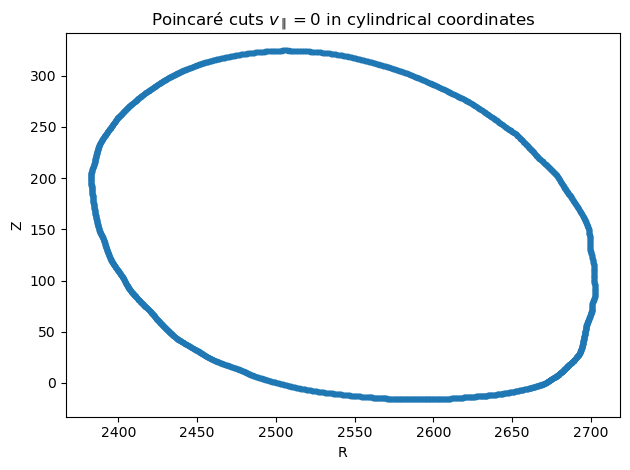

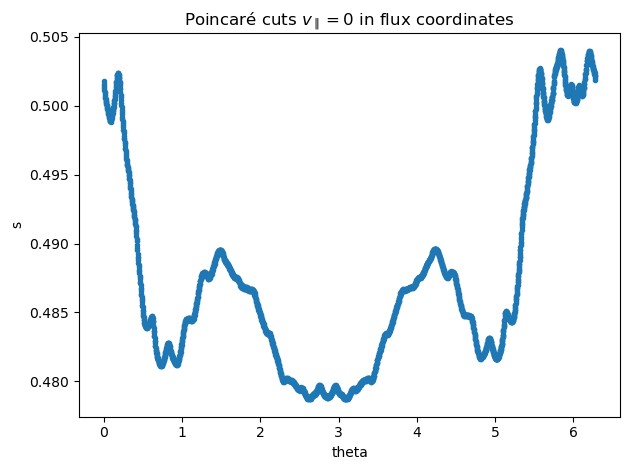

In [95]:
if (gorilla_plot['gorilla_plot_nml']['boole_poincare_vpar_0']):

    poincare_rphiz = np.genfromtxt(path_script2RUN + '/' + gorilla_plot['gorilla_plot_nml']['filename_poincare_vpar_0_rphiz'])
    poincare_sthetaphi = np.genfromtxt(path_script2RUN + '/' + gorilla_plot['gorilla_plot_nml']['filename_poincare_vpar_0_sthetaphi'])

    fig1 = plt.figure()
    plt.title('Poincaré cuts $v_{\parallel} = 0$ in cylindrical coordinates')
    plt.plot(poincare_rphiz[:,0],poincare_rphiz[:,2],'.')
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.tight_layout()
    fig1.savefig(path_data_plots + '/poincare_vpar_0_rphiz' + extension)
    plt.show()

    fig2 = plt.figure()
    plt.title('Poincaré cuts $v_{\parallel} = 0$ in flux coordinates')
    plt.plot(poincare_sthetaphi[:,1],poincare_sthetaphi[:,0],'.')
    plt.xlabel('theta')
    plt.ylabel('s')
    plt.tight_layout()
    fig2.savefig(path_data_plots + '/poincare_vpar_0_sthetaphi' +  extension)
    plt.show()
    

### 3D plot in cartesian coordinates

In [ ]:
if (gorilla_plot['gorilla_plot_nml']['boole_poincare_vpar_0']):

    poincare_rphiz = np.genfromtxt(path_script2RUN + '/' + gorilla_plot['gorilla_plot_nml']['filename_poincare_vpar_0_rphiz'])
    poincare_sthetaphi = np.genfromtxt(path_script2RUN + '/' + gorilla_plot['gorilla_plot_nml']['filename_poincare_vpar_0_sthetaphi'])

    fig1 = plt.figure()
    plt.title('Poincaré cuts $v_{\parallel} = 0$ in cylindrical coordinates')
    plt.plot(poincare_rphiz[:,0],poincare_rphiz[:,2],'.')
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.tight_layout()
    fig1.savefig(path_data_plots + '/poincare_vpar_0_rphiz' + extension)
    plt.show()

    fig2 = plt.figure()
    plt.title('Poincaré cuts $v_{\parallel} = 0$ in flux coordinates')
    plt.plot(poincare_sthetaphi[:,1],poincare_sthetaphi[:,0],'.')
    plt.xlabel('theta')
    plt.ylabel('s')
    plt.tight_layout()
    fig2.savefig(path_data_plots + '/poincare_vpar_0_sthetaphi' +  extension)
    plt.show()
    